In [1]:
import os
import sys
sys.path.append(os.getcwd())
sys.path.insert(0, "../porousequivariantnetworks/code/")
sys.path.insert(0, "../porousequivariantnetworks/")


import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.ticker as tick

from tqdm import tqdm


from models.equivariant_mpnn import MPNN, MPNNPORE
from utils.ZeoliteData import get_zeolite, get_data_pore, get_data_graph, get_data_megnet
from utils.dataloading import get_data, get_graph_data

#import tueplots 

from models.megnet import MEGNet
from models.cgcnn import CGCNN
from models.schnet import SchNet
from models.dimenet import DimeNetPlusPlus as DimeNet

In [2]:
import matplotlib as mpl

In [3]:
plt.rc('font', family='serif',)

In [4]:
from matplotlib import rc

In [5]:
data = get_zeolite('MFI', True)
    
ref = data['ref'] # reflections
tra = data['tra'] # translations
l = data['l'] # scale of the unit cell

# specific for MOR
atoms, hoa, X, A, d, X_pore, A_pore, d_pore, pore = get_data(l, 'MFI')

edges, idx1, idx2, idx2_oh = get_graph_data(A, d)
edges_sp, idx1_sp, idx2_sp, idx2_oh_sp = get_graph_data(A_pore, d_pore)
edges_ps, idx1_ps, idx2_ps, idx2_oh_ps = get_graph_data(A_pore.T, d_pore.T)

In [6]:
lim=22

In [7]:
_, testloader, trainloader = get_data_pore(atoms, hoa, edges, pore, edges_sp, edges_ps, bs=32, random=True)
_, testloader2, trainloader2 = get_data_graph(atoms, hoa, edges, bs=32, random=True)
_, testloader3, trainloader3 = get_data_megnet(atoms, hoa, edges, bs=32, random=True)

In [8]:
trainX = trainloader.dataset.X.sum((1,2))[:,None].numpy()
trainy = trainloader.dataset.y[:,None].numpy()
testX = testloader.dataset.X.sum((1,2))[:,None].numpy()
testy = testloader.dataset.y[:,None].numpy()

In [9]:
from sklearn.linear_model import LinearRegression as LR

In [10]:
lr = LR()
lr.fit(trainX, trainy)

LinearRegression()

In [11]:
yhat = lr.predict(testX)

In [12]:
lr_mse, lr_mae = np.mean((testy - yhat)**2), np.mean(np.abs(testy - yhat))

In [13]:
atoms.shape[0]

3296

In [14]:
title_size=7.5
label_size=7

In [15]:
hoa.min(), hoa.max()

(26.0163, 81.3185)

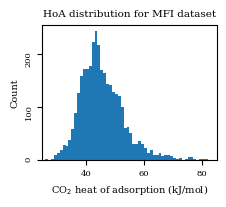

In [16]:
plt.figure(figsize=(2.25,1.75))
plt.hist(hoa, bins=np.arange(25,85,1))
plt.xlabel('CO$_2$ heat of adsorption (kJ/mol)', fontsize=label_size)
plt.ylabel('Count', fontsize=label_size)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6, rotation='vertical')
plt.title('HoA distribution for MFI dataset', fontsize=title_size)
plt.xlim(25,85)
plt.savefig('figures/datadist_mfi.pdf', dpi=1200, bbox_inches="tight")
tikzz = plt.xticks()[0]

In [17]:
hoa_x = np.tile(np.linspace(25,85,60)[:,None], (1,13))
hoa_y = np.tile(np.arange(0,13,1)[None], (hoa_x.shape[0],1))

In [18]:
zi = np.zeros((len(hoa_x),13))

for i in range(len(atoms)):
    
    curr_h = hoa[i]
    
    n_als = atoms[i].sum()
              
    for _x in range(0,len(hoa_x)-1):
        
        if hoa_x[_x, n_als//2] < curr_h <= hoa_x[_x+1, n_als//2]:
            zi[_x, n_als//2] += 1

In [19]:
zi.sum(0)

array([ 21.,  70., 320., 320., 320., 320., 320., 320., 290., 320., 320.,
       200., 155.])

In [20]:
zi = zi/zi.sum(0)[None]

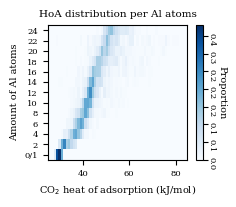

In [21]:
fig, ax = plt.subplots(figsize=(2.25,1.75))
CS = plt.pcolormesh(hoa_x, hoa_y, zi,
                  vmax=zi.max(), vmin=0, cmap='Blues')
#plt.colorbar()
plt.xlabel(f"CO$_2$ heat of adsorption (kJ/mol)", fontsize=label_size)
plt.ylabel(f"Amount of Al atoms", fontsize=label_size)
plt.title("HoA distribution per Al atoms", fontsize=title_size)
cbar = plt.colorbar()
plt.yticks(np.arange(0.,13, 1), ['0/1'] + np.arange(2,26,2).tolist(), fontsize=6, rotation='horizontal')
plt.xticks(tikzz)
plt.xticks(fontsize=6)
plt.xlim(25,85)
plt.ylim(-0.5,12.5)
cbar.ax.tick_params(labelsize=6, rotation=270,pad=0)
cbar.ax.get_yaxis().labelpad = 8
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.1f'))
cbar.set_label('Proportion', rotation=270, fontsize=label_size)
plt.savefig('figures/aldist_mfi.pdf', dpi=1200, bbox_inches="tight")

In [22]:
hoa_x.shape, hoa_y.shape, zi.shape

((60, 13), (60, 13), (60, 13))

In [23]:
mpnn = MPNNPORE(idx1.to('cuda'), idx2.to('cuda'), idx2_oh.to('cuda'), X, X_pore, ref, tra,
                    idx1_sp.to('cuda'), idx2_sp.to('cuda'), idx2_oh_sp.to('cuda'), 
                    idx1_ps.to('cuda'), idx2_ps.to('cuda'), idx2_oh_ps.to('cuda'),
                    hid_size=[8]*6, site_emb_size=8, edge_emb_size=8, mlp_size=24,
                    centers=10, mx_d=6, width=1, pool='sum', pool_pore=True).to('cuda')

mpnn2 = MPNN(idx1.to('cuda'), idx2.to('cuda'), idx2_oh.to('cuda'), X, ref, tra,
                        hid_size=[8]*6, site_emb_size=8, edge_emb_size=8, mlp_size=24,
                        centers=10, mx_d=6, width=1, pool='sum').to('cuda')
meg = MEGNet(idx1, idx2).cuda()

sch = SchNet(d).cuda()

cgcnn = CGCNN(idx1, idx2).cuda()

dimenet = DimeNet(idx1, idx2, torch.tensor(X), torch.tensor(l)).to('cuda')

In [24]:
def get_95_CI(x):
    
    ci = 1.96*np.std(x)/np.sqrt(len(x))
    return ci

In [25]:
# for j in (range(1,21)):
#     mpnn.load_state_dict(torch.load(f'model_data_random/MFI/1.0/pore/model_{j}/model.pth'))
#     y_pred, y_true = mpnn.predict(testloader)

#     _mse = ((y_pred - y_true)**2).mean().item()
#     _mae = (y_pred - y_true).abs().mean().item()
#     print(j, _mae, _mse)

In [26]:
#props = [1.]
props = [0.125, .25, .5, .75, 1.]
names = ['pore','equi', 'schnet']

mae_p = []
mse_p = []


mae_e = []
mse_e = []

mae_p_ci = []
mse_p_ci = []


mae_e_ci = []
mse_e_ci = []


mae_s = []
mse_s = []

mae_s_ci = []
mse_s_ci = []


for i in props:
    
    _mae_p = []
    _mse_p = []
    _mae_e = []
    _mse_e = []
    _mae_s = []
    _mse_s = []
    
    for j in tqdm(range(1,11)):
    
        mpnn.load_state_dict(torch.load(f'model_data_random/MFI/{i}/pore/model_{j}/model.pth'))
        y_pred, y_true = mpnn.predict(testloader)

        _mse = ((y_pred - y_true)**2).mean().item()
        _mae = (y_pred - y_true).abs().mean().item()

        _mae_p.append(_mae)
        _mse_p.append(_mse)

        mpnn2.load_state_dict(torch.load(f'model_data_random/MFI/{i}/equi/model_{j}/model.pth'))
        y_pred, y_true = mpnn2.predict(testloader2)

        _mse = ((y_pred - y_true)**2).mean().item()
        _mae = (y_pred - y_true).abs().mean().item()

        _mae_e.append(_mae)
        _mse_e.append(_mse)
    
    
        sch.load_state_dict(torch.load(f'model_data_random/MFI/{i}/schnet/model_{j}/model.pth'))
        y_pred, y_true = sch.predict(testloader2)

        _mse = ((y_pred - y_true)**2).mean().item()
        _mae = (y_pred - y_true).abs().mean().item()

        _mae_s.append(_mae)
        _mse_s.append(_mse)
    
    mae_p.append(np.mean(_mae_p))
    mse_p.append(np.mean(_mse_p))
    mae_e.append(np.mean(_mae_e))
    mse_e.append(np.mean(_mse_e))
    mae_s.append(np.mean(_mae_s))
    mse_s.append(np.mean(_mse_s))

    
    mae_p_ci.append(get_95_CI(_mae_p))
    mse_p_ci.append(get_95_CI(_mse_p))
    mae_e_ci.append(get_95_CI(_mae_e))
    mse_e_ci.append(get_95_CI(_mse_e))
    mae_s_ci.append(get_95_CI(_mae_s))
    mse_s_ci.append(get_95_CI(_mse_s))

    print(i)
    

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:12<00:00,  7.30s/it]


0.125


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:13<00:00,  7.33s/it]


0.25


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:13<00:00,  7.32s/it]


0.5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:13<00:00,  7.32s/it]


0.75


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:13<00:00,  7.31s/it]

1.0


In [27]:
mae_p_ci, mae_p

([0.047042265653670784,
  0.06695573101481055,
  0.09044464719390033,
  0.11648303301507995,
  0.04939898097844079],
 [2.5326247215270996,
  2.406538796424866,
  2.3107343196868895,
  2.236926865577698,
  1.99602153301239])

In [28]:
# mae_sch = []
# mse_sch = []

mae_meg = []
mse_meg = []

mae_cg = []
mse_cg = []

mae_dn = []
mse_dn = []

for j in range(1,11):
    
    # sch.load_state_dict(torch.load(f'model_data/1.0/schnet/model_{j}/model.pth'))

    # y_pred, y_true = sch.predict(testloader2)
    # _mse = ((y_pred - y_true)**2).mean().item()
    # _mae = (y_pred - y_true).abs().mean().item()

    # mae_sch.append(_mae)
    # mse_sch.append(_mse)

    meg.load_state_dict(torch.load(f'model_data_random/MFI/1.0/megnet/model_{j}/model.pth'))
    y_pred, y_true = meg.predict(testloader3)

    _mse = ((y_pred - y_true)**2).mean().item()
    _mae = (y_pred - y_true).abs().mean().item()

    mae_meg.append(_mae)
    mse_meg.append(_mse)
    
    
    cgcnn.load_state_dict(torch.load(f'model_data_random/MFI/1.0/cgcnn/model_{j}/model.pth'))
    y_pred, y_true = cgcnn.predict(testloader2)

    _mse = ((y_pred - y_true)**2).mean().item()
    _mae = (y_pred - y_true).abs().mean().item()

    mae_cg.append(_mae)
    mse_cg.append(_mse)
    
    dimenet.load_state_dict(torch.load(f'model_data_random/MFI/1.0/dime/model_{j}/model.pth'))
    y_pred, y_true = dimenet.predict(testloader2)

    _mse = ((y_pred - y_true)**2).mean().item()
    _mae = (y_pred - y_true).abs().mean().item()

    mae_dn.append(_mae)
    mse_dn.append(_mse)
    
    print(j)
    

1
2
3
4
5
6
7
8
9
10


In [29]:
_mae_p

[2.0367672443389893,
 2.0880300998687744,
 1.9895236492156982,
 1.8426415920257568,
 1.8572438955307007,
 2.0345001220703125,
 1.975002408027649,
 2.059619426727295,
 2.0608372688293457,
 2.01604962348938]

In [30]:
maes = [mae_dn, mae_cg, mae_meg, _mae_s, _mae_e, _mae_p]
mses = [mse_dn, mse_cg, mse_meg, _mse_s, _mse_e, _mse_p]

In [31]:
_mae_p

[2.0367672443389893,
 2.0880300998687744,
 1.9895236492156982,
 1.8426415920257568,
 1.8572438955307007,
 2.0345001220703125,
 1.975002408027649,
 2.059619426727295,
 2.0608372688293457,
 2.01604962348938]

In [32]:
df = pd.DataFrame(columns = ['MAE','MSE'], index=['Linear Regression','DimeNet','CGCNN','MEGNet','SchNet','Ours (without pores)', 'Ours (with pores)'])
for i in range(len(df.index)):
    
    if i == 0:
        a = np.round(lr_mae, 3)
        s = np.round(lr_mse, 3)
    else:
        mu_a = np.mean(maes[i-1]).round(3)
        mu_s = np.mean(mses[i-1]).round(3)
        
        ci_a = get_95_CI(maes[i-1]).round(3)
        ci_s = get_95_CI(mses[i-1]).round(3)
        
        
        a = fr'{mu_a} $$\pm$$ {ci_a}'
        s = fr'{mu_s} $$\pm$$ {ci_s}'
        
    df.loc[df.index[i]] = [a,s]

In [33]:
df

,MAE,MSE
Linear Regression,3.045,20.097
DimeNet,2.862 $$\pm$$ 0.027,19.344 $$\pm$$ 0.472
CGCNN,2.77 $$\pm$$ 0.06,18.545 $$\pm$$ 0.842
MEGNet,2.733 $$\pm$$ 0.063,19.024 $$\pm$$ 1.068
SchNet,2.257 $$\pm$$ 0.052,10.953 $$\pm$$ 0.471
Ours (without pores),2.009 $$\pm$$ 0.06,8.819 $$\pm$$ 0.416
Ours (with pores),1.996 $$\pm$$ 0.049,9.012 $$\pm$$ 0.344


In [34]:
print(df.to_latex(escape=False))

\begin{tabular}{lll}
\toprule
 & MAE & MSE \\
\midrule
Linear Regression & 3.045000 & 20.097000 \\
DimeNet & 2.862 $$\pm$$ 0.027 & 19.344 $$\pm$$ 0.472 \\
CGCNN & 2.77 $$\pm$$ 0.06 & 18.545 $$\pm$$ 0.842 \\
MEGNet & 2.733 $$\pm$$ 0.063 & 19.024 $$\pm$$ 1.068 \\
SchNet & 2.257 $$\pm$$ 0.052 & 10.953 $$\pm$$ 0.471 \\
Ours (without pores) & 2.009 $$\pm$$ 0.06 & 8.819 $$\pm$$ 0.416 \\
Ours (with pores) & 1.996 $$\pm$$ 0.049 & 9.012 $$\pm$$ 0.344 \\
\bottomrule
\end{tabular}



In [35]:
np.mean(_mae_p), get_95_CI(_mae_p), np.mean(_mae_s), get_95_CI(_mae_s)

(1.99602153301239,
 0.04939898097844079,
 2.2574984788894654,
 0.051818351185967615)

In [36]:
mae_p = np.array(mae_p)
mse_p = np.array(mse_p)
mae_e = np.array(mae_e)
mse_e = np.array(mse_e)
mae_s = np.array(mae_s)
mse_s = np.array(mse_s)

mae_p_ci = np.array(mae_p_ci)
mse_p_ci = np.array(mse_p_ci)
mae_e_ci = np.array(mae_e_ci)
mse_e_ci = np.array(mse_e_ci)
mae_s_ci = np.array(mae_s_ci)
mse_s_ci = np.array(mse_s_ci)

In [37]:
props2 = np.array(props)*len(trainloader.dataset)

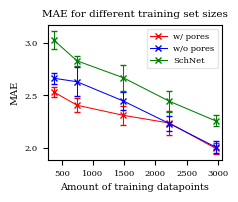

In [40]:
plt.figure(figsize=(2.25,1.75))
plt.plot(props2, mae_p, c='red', label = 'w/ pores', marker='x', markersize=3.75, lw=.75)
plt.errorbar(props2, mae_p, mae_p_ci, c='red', capsize=2.5, fmt='none', lw=.75)
#plt.fill_between(props2, mae_p-mae_p_ci, mae_p+mae_p_ci, color='red', alpha=.3)
plt.plot(props2, mae_e, c='blue', label = 'w/o pores', marker='x', markersize=3.75, lw=.75)
plt.errorbar(props2, mae_e, mae_e_ci, c ='blue', capsize=2.5, fmt='none', lw=.75)
#plt.fill_between(props2, mae_e-mae_e_ci, mae_e+mae_e_ci, color='blue', alpha=.3)
plt.plot(props2, mae_s, c='green', label = 'SchNet', marker='x', markersize=3.75, lw=.75)
plt.errorbar(props2, mae_s, mae_s_ci,c='green', capsize=2.5, fmt='none', lw=.75)
#plt.fill_between(props2, mae_s-mae_s_ci, mae_s+mae_s_ci, color='green', alpha=.3)

plt.xlabel('Amount of training datapoints', fontsize=label_size)
plt.ylabel('MAE', fontsize=label_size)
plt.title('MAE for different training set sizes', fontsize=title_size)
plt.legend(fontsize=6, loc='upper right', framealpha=0.5)
plt.xticks(np.arange(500, 3500, 500), fontsize=6)
plt.yticks(fontsize=6)
plt.xlim(props2.min()-100, props2.max()+100)
#plt.ylim(2,5)
plt.savefig('figures/mae2_mfi_int.pdf', dpi=1200, bbox_inches = "tight")
#plt.savefig('figures/mae2.eps', dpi=1200, bbox_inches = "tight");

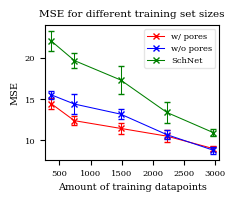

In [41]:
plt.figure(figsize=(2.25,1.75))
plt.plot(props2, mse_p, c='red', label = 'w/ pores', marker='x', markersize=3.75, lw=.75)
plt.errorbar(props2, mse_p, mse_p_ci, c='red', capsize=2.5, fmt='none', lw=.75)
plt.plot(props2, mse_e, c='blue', label = 'w/o pores', marker='x', markersize=3.75, lw=.75)
plt.errorbar(props2, mse_e, mse_e_ci, c ='blue', capsize=2.5, fmt='none', lw=.75)
plt.plot(props2, mse_s, c='green', label = 'SchNet', marker='x', markersize=3.75, lw=.75)
plt.errorbar(props2, mse_s, mse_s_ci,c='green', capsize=2.5, fmt='none', lw=.75)

plt.xlabel('Amount of training datapoints', fontsize=label_size)
plt.ylabel('MSE', fontsize=label_size)
plt.title('MSE for different training set sizes', fontsize=title_size)
plt.legend(fontsize=6, loc='upper right', framealpha=0.5)
plt.xticks(np.arange(500, 3500, 500), fontsize=6)
plt.yticks(fontsize=6)
plt.xlim(props2.min()-100, props2.max()+100)
plt.savefig('figures/mse2_mfi_int.pdf', dpi=1200, bbox_inches = "tight")


In [42]:
best_idx = np.argmin(_mae_p)
mpnn.load_state_dict(torch.load(f'model_data_random/MFI/1.0/pore/model_{best_idx+1}/model.pth'))
y_pred, y_true = mpnn.predict(testloader)

In [43]:
from scipy.interpolate import griddata

In [44]:
y_pred.min(), y_pred.max(), y_true.min(), y_true.max()

(tensor(29.9785), tensor(73.6181), tensor(29.4428), tensor(77.3927))

In [45]:
Z = torch.ones_like(y_pred)

In [46]:
nn = 60
xmin = 25
xmax = 80
xi = np.linspace(xmin, xmax, nn)
yi = np.linspace(xmin, xmax, nn)

In [47]:
zi = np.zeros((nn,nn))

for i in range(len(y_pred)):
    
    curr_p = y_pred[i].item()
    curr_t = y_true[i].item()
    
    for _x in range(0,nn-1):
        
        if xi[_x] < curr_p <= xi[_x+1]:
            
            for _y in range(0,nn-1):
                
                if yi[_y] < curr_t <= xi[_y+1]:
                    
                    zi[_x,_y] += 1

In [62]:
len(np.unique(zi)), np.unique(zi), zi.max()

(8, array([0., 1., 2., 3., 4., 5., 6., 8.]), 8.0)

In [53]:
n_colors = int(zi.max())

C:\Users\20175552\AppData\Local\Temp\ipykernel_19252\522922956.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Blues', n_colors+1)


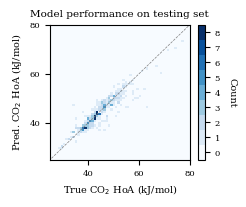

In [63]:
fig, ax = plt.subplots(figsize=(2.25,1.75))
cmap = plt.cm.get_cmap('Blues', n_colors+1)
CS = plt.pcolormesh(xi, yi, zi,
                  vmax=zi.max(), vmin=0, cmap=cmap)
plt.xlabel(f"True CO$_2$ HoA (kJ/mol)", fontsize=label_size)
plt.ylabel(f"Pred. CO$_2$ HoA (kJ/mol)", fontsize=label_size)
plt.title("Model performance on testing set", fontsize=title_size)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".5", lw=.5)
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 12
cbar.set_label('Count', rotation=270, fontsize=label_size)
cbar.ax.get_yaxis().set_ticks(np.arange((n_colors)/(2*(n_colors+1)), n_colors, (n_colors)/(n_colors+1)), np.arange(n_colors+1) )
cbar.ax.tick_params(labelsize=6)
plt.xticks(plt.yticks()[0])
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)

plt.savefig('figures/truepred_mfi_int.pdf', dpi=1200, bbox_inches="tight")